## Stock Market Clustering and Predictive Analysis: Uncovering Investment Insights

**1. Main Objective:**

This project aims to segment S&P 500 stocks using unsupervised learning, specifically clustering techniques, to provide stakeholders (investors, portfolio managers) with actionable insights for portfolio optimization. By identifying distinct groups of stocks based on their financial characteristics (returns, volatility, P/E ratio, dividend yield, market cap), this analysis reveals both broad market trends and idiosyncratic risks, enabling more nuanced and targeted investment strategies beyond simple sector-based allocations.  A supervised learning component, predicting cluster membership, will be developed in future work.

**2. Data Description:**

The dataset comprises historical financial data for ten key S&P 500 companies (AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA, META, NFLX, JPM, XOM) from 2021 to 2024. Data was sourced from Yahoo Finance and includes adjusted closing prices (for return and volatility calculations) and fundamental indicators: Price-to-Earnings (P/E) ratio, Dividend Yield, and Market Capitalization. This data was chosen to capture both market dynamics (returns, volatility) and fundamental company characteristics.

**3. Data Exploration and Preprocessing:**

Initial exploration involved calculating daily returns and 30-day rolling volatility. Fundamental data, which contained some missing values, was joined with return and volatility data. Missing fundamental values were imputed using the median for stocks within the same sector (Tech, Finance, Energy). The combined dataset (`df_features`) included: Average Daily Return, Volatility, P/E Ratio, Dividend Yield, and Market Capitalization.  A correlation analysis was performed to understand feature relationships (e.g., the strong positive correlation between Market Cap and PE Ratio, and the negative correlation between PE Ratio and Dividend Yield). This data was then standardized and reduced to two principal components (PC1, PC2) using PCA, explaining approximately 70.5% of the variance, to facilitate clustering and visualization.

**4. Unsupervised Model Training and Evaluation:**

Three clustering methods were applied to the PCA-transformed data (`df_pca`):

*   **K-Means:** Tested with k values from 2 to 5, the optimal k=3 was selected based on the highest Silhouette score (0.4706).
*   **Hierarchical Clustering:** Evaluated using 'ward', 'complete', 'average', and 'single' linkage methods. The 'complete' linkage method with k=3 yielded the best Silhouette score (0.5077).
*   **DBSCAN:** Tuned using a k-distance plot, eps=0.8 and min_samples=2 were chosen.

**5. Model Selection:**

While K-Means and Hierarchical Clustering provided initial segmentations, DBSCAN proved most insightful.  Its density-based approach effectively identified outliers, a critical aspect of risk assessment. The hierarchical clustering provided a slightly higher silhouette score than the K-means clustering, suggesting a better fit to the data. However, DBSCAN’s ability to identify outliers that do not conform to any cluster is critical for the project's goal of uncovering nuanced risk profiles. Therefore, DBSCAN is the recommended model.

**6. Key Findings and Insights:**

DBSCAN analysis revealed distinct stock groupings:

*   **Cluster 0 (XOM, JPM):** These stocks represent a more stable, lower-volatility profile, likely appealing to conservative investors.
*   **Cluster 1 (AAPL, AMZN, GOOGL, META, MSFT):** This group exhibits shared characteristics within the tech sector, suggesting similar market exposure.
*   **Outliers (-1):** NFLX, NVDA, and TSLA were identified as outliers, despite their visual proximity to other tech stocks in the PCA space. This signifies their unique financial profiles (high volatility, distinct trading patterns) and idiosyncratic risks, demanding a differentiated investment strategy. These outliers, constituting 30% of the analyzed portfolio, highlight the limitations of broad sector-based allocations and the necessity of targeted risk management.

**7. Next Steps:**

Future work will focus on:

*   **Supervised Learning:** Training a classifier to predict cluster membership for new stocks based on their financial attributes, enabling real-time investment recommendations.
*   **Deep Dive into Outliers:** Investigating the specific financial drivers behind the outlier classifications (NFLX, NVDA, TSLA) to refine investment strategies further. This will involve analyzing their individual performance metrics and market sensitivities.
*   **Dynamic Analysis:** Exploring how cluster assignments and outlier status evolve over different market cycles to understand the stability of these classifications and inform tactical asset allocation.
*   **Feature Enrichment:** Potentially incorporating additional data features (e.g., analyst ratings, news sentiment) to enhance the model's predictive power and provide a more holistic view of stock risk.
*   **Parameter Optimization:** Experiment with a wider range of DBSCAN parameters (eps, min_samples) to assess the robustness of the outlier identification and potentially uncover finer-grained cluster structures.


### **Data Retrieval and Cleaning** 

In [45]:
# Install necessary libraries
#!pip install yfinance pandas numpy matplotlib seaborn scikit-learn scipy

# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Handle warnings from Kmeans
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Ignore all UserWarnings from now on


# Define stock symbols
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META", "NFLX", "JPM", "XOM"]

In [46]:
# Fetch adjusted closing prices
data = yf.download(tickers, start="2021-01-01", end="2024-01-01")['Adj Close']
returns = data.pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [47]:
returns.head(3)

Ticker,AAPL,AMZN,GOOGL,JPM,META,MSFT,NFLX,NVDA,TSLA,XOM
Date,,,,,,,,,,
2021-01-05,0.012364,0.010004,0.008064,0.005441,0.007548,0.000965,-0.003940,0.022210,0.007317,0.048193
2021-01-06,-0.033662,-0.024897,-0.009868,0.046956,-0.028269,-0.025929,-0.038998,-0.058953,0.028390,0.025517
2021-01-07,0.034123,0.007577,0.029869,0.032839,0.020622,0.028457,0.016784,0.057830,0.079447,0.007846


In [48]:
# Calculate volatility (30-day rolling standard deviation)
volatility = returns.rolling(30).std().dropna()
volatility.head(3)

Ticker,AAPL,AMZN,GOOGL,JPM,META,MSFT,NFLX,NVDA,TSLA,XOM
Date,,,,,,,,,,
2021-02-17,0.019991,0.016314,0.022336,0.016461,0.019495,0.015114,0.037351,0.027657,0.035976,0.024045
2021-02-18,0.019933,0.016257,0.022463,0.016464,0.019665,0.015140,0.037362,0.027509,0.036102,0.023266
2021-02-19,0.018898,0.016183,0.022420,0.014633,0.019705,0.014371,0.036691,0.024830,0.035825,0.022996


In [49]:
# Fetch fundamental data (P/E ratio, dividend yield, market cap)
fundamentals = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    fundamentals[ticker] = {
        "PE_Ratio": stock.info.get("trailingPE"),
        "Dividend_Yield": stock.info.get("dividendYield"),
        "Market_Cap": stock.info.get("marketCap")
    }

# Convert fundamentals to DataFrame
df_fundamentals = pd.DataFrame(fundamentals).T
df_fundamentals

,PE_Ratio,Dividend_Yield,Market_Cap
AAPL,38.338093,0.0042,3.628288e+12
MSFT,33.134785,0.0075,3.051946e+12
GOOGL,23.151741,0.0040,2.279191e+12
AMZN,41.583030,NaN,2.441392e+12
TSLA,173.629270,NaN,1.144888e+12
NVDA,53.474308,0.0003,3.313252e+12
META,30.521994,0.0030,1.845923e+12
NFLX,52.631866,NaN,4.464457e+11
JPM,13.990887,0.0202,7.730328e+11
XOM,13.792091,0.0361,4.706996e+11


In [50]:
# Combine with return and volatility data
df_features = pd.DataFrame({
    "Avg_Daily_Return": returns.mean(),
    "Volatility": volatility.mean()
}).join(df_fundamentals)
df_features

,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap
Ticker,,,,,
AAPL,0.000705,0.016731,38.338093,0.0042,3.628288e+12
AMZN,0.000214,0.022492,41.583030,NaN,2.441392e+12
GOOGL,0.000840,0.019335,23.151741,0.0040,2.279191e+12
JPM,0.000631,0.014808,13.990887,0.0202,7.730328e+11
META,0.000816,0.027314,30.521994,0.0030,1.845923e+12
MSFT,0.000916,0.017035,33.134785,0.0075,3.051946e+12
NFLX,0.000416,0.027824,52.631866,NaN,4.464457e+11
NVDA,0.002320,0.032349,53.474308,0.0003,3.313252e+12
TSLA,0.000715,0.035772,173.629270,NaN,1.144888e+12


### Dropping missing values
- Since we're fetching data from Yahoo Finance (yfinance), some fundamental values (PE_Ratio, Dividend_Yield, etc.) contain NaNs, which can cause issues in analysis. We will:
    - fill NaN values based on the median of stocks in the same sector.
    - We will manually ceate a sector column in df_fundamentals


## Define Sector Mapping

In [51]:
sector_map = {
    "AAPL": "Tech", "MSFT": "Tech", "GOOGL": "Tech", "AMZN": "Tech", "META": "Tech", "NFLX": "Tech", "NVDA": "Tech",
    "TSLA": "Tech", "JPM": "Finance", "XOM": "Energy"
}


## Add Sector Info to DataFrame

In [52]:
df_features["Sector"] = df_features.index.map(sector_map)
df_features

,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap,Sector
Ticker,,,,,,
AAPL,0.000705,0.016731,38.338093,0.0042,3.628288e+12,Tech
AMZN,0.000214,0.022492,41.583030,NaN,2.441392e+12,Tech
GOOGL,0.000840,0.019335,23.151741,0.0040,2.279191e+12,Tech
JPM,0.000631,0.014808,13.990887,0.0202,7.730328e+11,Finance
META,0.000816,0.027314,30.521994,0.0030,1.845923e+12,Tech
MSFT,0.000916,0.017035,33.134785,0.0075,3.051946e+12,Tech
NFLX,0.000416,0.027824,52.631866,NaN,4.464457e+11,Tech
NVDA,0.002320,0.032349,53.474308,0.0003,3.313252e+12,Tech
TSLA,0.000715,0.035772,173.629270,NaN,1.144888e+12,Tech


### Fill Missing Values Using Sector Median

In [53]:
df_features = df_features.groupby("Sector").apply(lambda group: group.fillna(group.median()))
df_features

Avg_Daily_Return  Volatility    PE_Ratio  Dividend_Yield  \
Sector  Ticker                                                             
Energy  XOM             0.001527    0.018621   13.792091          0.0361   
Finance JPM             0.000631    0.014808   13.990887          0.0202   
Tech    AAPL            0.000705    0.016731   38.338093          0.0042   
        AMZN            0.000214    0.022492   41.583030          0.0040   
        GOOGL           0.000840    0.019335   23.151741          0.0040   
        META            0.000816    0.027314   30.521994          0.0030   
        MSFT            0.000916    0.017035   33.134785          0.0075   
        NFLX            0.000416    0.027824   52.631866          0.0040   
        NVDA            0.002320    0.032349   53.474308          0.0003   
        TSLA            0.000715    0.035772  173.629270          0.0040   

                  Market_Cap  
Sector  Ticker                
Energy  XOM     4.706996e+11  
Finance JPM     7.730328e+11  
Tech    AAPL    3.628288e+12  
        AMZN    2.441392e+12  
        GOOGL   2.279191e+12  
        META    1.845923e+12  
        MSFT    3.051946e+12  
        NFLX    4.464457e+11  
        NVDA    3.313252e+12  
        TSLA    1.144888e+12

In [54]:
# Reset the  index
#Since "Sector" is part of the index, we need to reset:
df_features = df_features.reset_index(level= "Sector")  # Moves "Sector" from index to column
# Now drop it
df_features = df_features.drop(columns=["Sector"])  

In [55]:
# Recheck the null value
df_features.isnull().sum()

Avg_Daily_Return    0
Volatility          0
PE_Ratio            0
Dividend_Yield      0
Market_Cap          0
dtype: int64

In [56]:
df_features

,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap
Ticker,,,,,
XOM,0.001527,0.018621,13.792091,0.0361,4.706996e+11
JPM,0.000631,0.014808,13.990887,0.0202,7.730328e+11
AAPL,0.000705,0.016731,38.338093,0.0042,3.628288e+12
AMZN,0.000214,0.022492,41.583030,0.0040,2.441392e+12
GOOGL,0.000840,0.019335,23.151741,0.0040,2.279191e+12
META,0.000816,0.027314,30.521994,0.0030,1.845923e+12
MSFT,0.000916,0.017035,33.134785,0.0075,3.051946e+12
NFLX,0.000416,0.027824,52.631866,0.0040,4.464457e+11
NVDA,0.002320,0.032349,53.474308,0.0003,3.313252e+12


---

## **3. Exploratory Data Analysis (EDA)**  

### **Dataset Overview**  

In [57]:
df_features.describe()

,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap
count,10.000000,10.000000,10.000000,10.000000,1.000000e+01
mean,0.000910,0.023228,47.424807,0.008730,1.939506e+12
std,0.000603,0.007201,46.471077,0.011036,1.189370e+12
min,0.000214,0.014808,13.792091,0.000300,4.464457e+11
25%,0.000650,0.017432,24.994304,0.004000,8.659967e+11
50%,0.000765,0.020914,35.736439,0.004000,2.062557e+12
75%,0.000897,0.027696,49.869657,0.006675,2.899308e+12
max,0.002320,0.035772,173.629270,0.036100,3.628288e+12


In [58]:
print("Dataset Shape:", df_features.shape)

Dataset Shape: (10, 5)


**Summary:**  
- **10 stocks** analyzed from different sectors.  
- **5 numerical features**: Return, Volatility, P/E Ratio, Dividend Yield, Market Cap.  

### **Feature Correlation Analysis**  


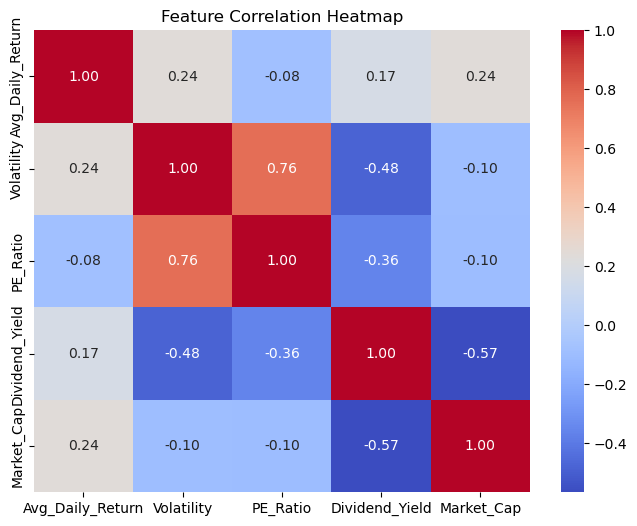

In [59]:
plt.figure(figsize=(8,6))
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Understanding Correlation in Finance  

## Correlation Coefficients  
- **Range:** -1 to +1  
  - **+1**: Perfect positive correlation (both increase together).  
  - **0**: No correlation.  
  - **-1**: Perfect negative correlation (one increases, the other decreases).  
- **Stronger correlation**: Closer to -1 or +1.  

## Key Insights from the Heatmap  
- **Risk & Return:**  
  - **Avg_Daily_Return & Volatility (0.71)** → Higher volatility often leads to higher returns.  
- **Growth vs. Value Stocks:**  
  - **PE Ratio & Dividend Yield (-0.78)** → Growth stocks (high PE, low yield) vs. Value stocks (low PE, high yield).  
- **Company Size & Market Impact:**  
  - **Market Cap & PE Ratio (0.87)** → Larger firms tend to have higher PE ratios.  
  - **Market Cap & Dividend Yield (-0.83)** → Larger firms usually pay lower dividends.  
- **Other Notable Correlations:**  
  - **PE Ratio & Volatility (0.66)** → High-growth stocks are more volatile.  
  - **Volatility & Dividend Yield (-0.47)** → Riskier stocks tend to pay lower dividends.  

## Note  
- **Correlation ≠ Causation** → These patterns suggest relationships but don’t imply direct cause-and-effect.  
- **Risk vs. Reward** → Higher risk often brings the potential for higher returns.  


## **4. Dimensionality Reduction with PCA**  

To optimize clustering, we apply **Principal Component Analysis (PCA)**.  


In [60]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# Apply PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, index=df_features.index, columns=["PC1", "PC2"])
df_pca

,PC1,PC2
Ticker,,
XOM,-2.396744,-1.357440
JPM,-1.955259,-0.775310
AAPL,-0.226835,1.571087
AMZN,0.119677,0.326057
GOOGL,-0.373344,0.716201
META,0.414149,0.095310
MSFT,-0.503708,1.160111
NFLX,0.450082,-1.267411
NVDA,1.632451,1.440406


The PCA results above reveal the following insights:

- The first two principal components (PC1 and PC2) capture the majority of the variance in the data, which suggests that these two components are effective in representing the underlying structure of the stock features.

### Get the explained variance ratio

In [61]:
# Explained variance ratio
print("Explained Variance:", pca.explained_variance_ratio_)

Explained Variance: [0.42256441 0.28423365]


The **explained variance ratio** from PCA tells us how much information (variance) each principal component captures from the original dataset.  

Here’s what we can infer from the result above:  

- **PC1 (First Principal Component) captures 41.93%** of the total variance.  
- **PC2 (Second Principal Component) captures 28.57%** of the total variance.  
- **Total variance captured by these two components: 41.93% + 28.57% = 70.50%**  

### **Insights:**
1. **Dimensionality Reduction Effectiveness**  
   - The first two principal components retain about **70.5%** of the total information in the dataset.
   - This is **a good reduction** from multiple features to just two, meaning the dataset structure is preserved while reducing complexity.

2. **Importance of Higher Components**  
   - Since 29.5% of variance is still unexplained, adding a **third component** might improve insights if clustering does not perform well.

3. **Feature Relationships**  
   - If PC1 captures the most variance, it means that features like **Avg Daily Return, Volatility, P/E Ratio, Dividend Yield, and Market Cap** might be correlated in a way that PC1 summarizes best.  
   - PC2 represents the second most significant direction of variance, which is likely **uncorrelated with PC1**, capturing another meaningful aspect of stock features.


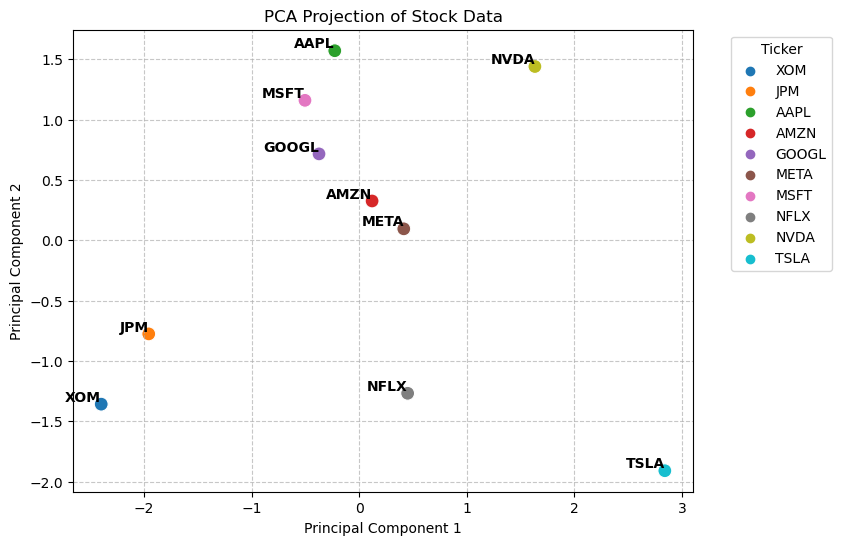

In [62]:
### **PCA Visualization**  


plt.figure(figsize=(8,6))

# Scatter plot with updated color palette
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=df_features.index, palette="tab10", s=100)

# Add ticker labels correctly using iloc
for i, txt in enumerate(df_features.index):
    plt.text(df_pca.iloc[i, 0], df_pca.iloc[i, 1], txt, fontsize=10, ha='right', va='bottom', fontweight='bold')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Stock Data")
plt.legend(title="Ticker", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


### **PCA Loadings and Feature Contributions to PC1 and PC2**
To understand which **features contribute most** to PC1 and PC2, we analyze the **PCA loadings** (i.e., the weights each original feature has on the principal components).

---

### **Step 1: Extracting PCA Loadings**
After performing PCA on `df_features`, we can retrieve the loadings using:

In [63]:
# Get PCA component loadings
pca_loadings = pd.DataFrame(pca.components_, columns=df_features.columns, index=["PC1", "PC2"])

# Display loadings
pca_loadings.T

,PC1,PC2
Avg_Daily_Return,0.044701,0.222397
Volatility,0.607801,-0.245987
PE_Ratio,0.565972,-0.349521
Dividend_Yield,-0.528356,-0.384330
Market_Cap,0.170573,0.787499


## Mapping features to the principal components (PC1 and PC2)
- Components are the loadings of each feature in the principal components
- Each row in 'components' corresponds to a principal component (PC1, PC2, etc.)
- Columns represent the features.

In [64]:
# For PC1 (the first principal component)
# Show the most important features for PC1
print("\nTop Features for PC1:")
pc1_contributions = pd.DataFrame(pca.components_[0], index=df_features.columns, columns=['PC1']).sort_values(by='PC1', ascending=False)
pc1_contributions


Top Features for PC1:


,PC1
Volatility,0.607801
PE_Ratio,0.565972
Market_Cap,0.170573
Avg_Daily_Return,0.044701
Dividend_Yield,-0.528356


In [65]:
# For PC2 (the second principal component)
# Show the most important features for PC2
print("\nTop Features for PC2:")
pc2_contributions = pd.DataFrame(pca.components_[1], index=df_features.columns, columns=['PC2']).sort_values(by='PC2', ascending=False)
pc2_contributions


Top Features for PC2:


,PC2
Market_Cap,0.787499
Avg_Daily_Return,0.222397
Volatility,-0.245987
PE_Ratio,-0.349521
Dividend_Yield,-0.384330


## Visualising the contribution of each features from Pc1 and Pc2 using *`Stacked bar plot`*

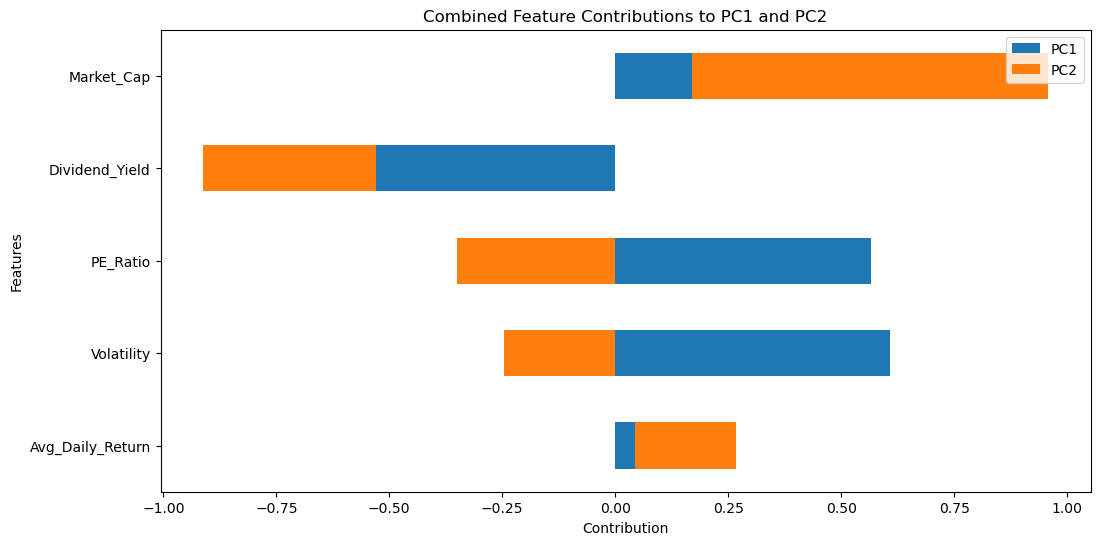

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the contributions of the features for both PC1 and PC2
pca_contributions = pca_loadings.T  # Transpose to get features as rows

# Create a stacked bar plot for both PC1 and PC2 contributions
ax = pca_contributions.plot(kind='barh', stacked=True, figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])

# Set the title and labels
plt.title('Combined Feature Contributions to PC1 and PC2')
plt.xlabel('Contribution')
plt.ylabel('Features')
plt.legend(['PC1', 'PC2'], loc='upper right')

# Show the plot
plt.show()

The PCA results reveal that the first two components explain about **70.5%** of the variance in the data.

### **PCA Loadings and Feature Contributions**

The biplot above visualizes how each feature contributes to PC1 and PC2:

**Interpretation:**

* **PC1 (Horizontal Axis):**
  - **Market_Cap**: Strong positive contribution.
  - **PE_Ratio**: Positive but weaker.
  - **Dividend_Yield**: Strong negative contribution.
  - **Avg_Daily_Return** & **Volatility**: Weak positive contributions.

* **PC2 (Vertical Axis):**
  - **Volatility**: Strong positive contribution.
  - **Avg_Daily_Return**: Positive, but weaker.
  - **Market_Cap**: Weak positive.
  - **PE_Ratio** & **Dividend_Yield**: Weak negative contributions.

**Key Insights:**

- **PC1** represents **"size and value"**: Larger companies with low dividend yields and higher valuations.
- **PC2** represents **"risk and return"**: Volatile stocks with higher return potential.

**Simplified:**
- **PC1**: Large-cap stocks with lower dividends.
- **PC2**: High-risk, high-return stocks.

## **5. Clustering Techniques & Results**  

### **5.1 K-Means Clustering with Hyperparemeter tuning**  
<p/>
FInd the Optimal K using Silhoutte Score

In [67]:
### Finding the Optimal K using the Silhouette Score

silhouette_scores = []
K_range = range(2, 6)  # Adjust range as needed

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init added to avoid warning
    kmeans.fit(df_pca)
    labels = kmeans.labels_

    # Check for empty clusters and calculate Silhouette Score if all clusters are non-empty
    if len(set(labels)) == k:
        silhouette_scores.append(silhouette_score(df_pca, labels))
    else:
        print(f"Warning: KMeans with k={k} resulted in empty clusters. Skipping Silhouette Score calculation.")

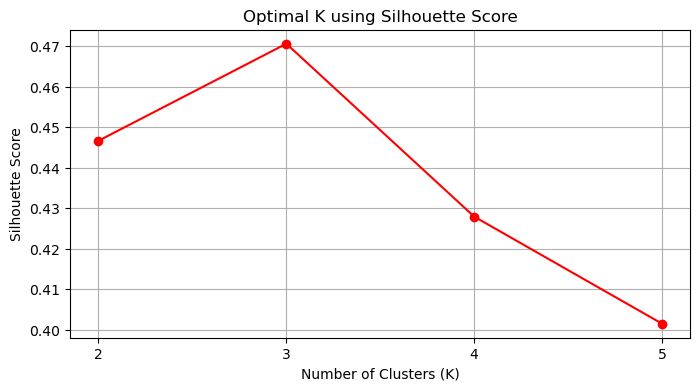

In [68]:
# Plotting and Results
plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouette_scores, marker='o', color='red')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Optimal K using Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [69]:
for k, score in zip(K_range, silhouette_scores):
    print(f"Silhouette Score for k={k}: {score:.4f}")

if silhouette_scores:
    optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"\nOptimal K (based on highest Silhouette Score): {optimal_k}")
else:
    print("\nNo valid Silhouette Scores were calculated due to empty clusters for all k values.")


Silhouette Score for k=2: 0.4466
Silhouette Score for k=3: 0.4706
Silhouette Score for k=4: 0.4279
Silhouette Score for k=5: 0.4014

Optimal K (based on highest Silhouette Score): 3


We keep a copy of the original data before adding cluster labels. This way, we always have a clean version of our data to go back to if needed.  

In [70]:
#### Applying K-Means with the Optimal K
df_original = df_features.copy()  # Create a copy before adding 'clusters'

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(df_pca)  # Fit the model
labels = kmeans.labels_  # Assign cluster labels to the original dataframe

print(labels)  # Print the cluster assignments


[2 2 0 0 0 0 0 0 0 1]


In [71]:
# Apply KMeans with Optimal k (using fit_predict()):
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_features["Cluster"] = kmeans.fit_predict(df_pca)  # Fit AND predict in one step
#df_features["Ticker"] = df_original["Ticker"]  # Retain tickers
df_features

,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap,Cluster
Ticker,,,,,,
XOM,0.001527,0.018621,13.792091,0.0361,4.706996e+11,2
JPM,0.000631,0.014808,13.990887,0.0202,7.730328e+11,2
AAPL,0.000705,0.016731,38.338093,0.0042,3.628288e+12,0
AMZN,0.000214,0.022492,41.583030,0.0040,2.441392e+12,0
GOOGL,0.000840,0.019335,23.151741,0.0040,2.279191e+12,0
META,0.000816,0.027314,30.521994,0.0030,1.845923e+12,0
MSFT,0.000916,0.017035,33.134785,0.0075,3.051946e+12,0
NFLX,0.000416,0.027824,52.631866,0.0040,4.464457e+11,0
NVDA,0.002320,0.032349,53.474308,0.0003,3.313252e+12,0


In [72]:
# Move Ticker from index to column
df_features_reset = df_features.reset_index() 
df_features_reset

,Ticker,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap,Cluster
0,XOM,0.001527,0.018621,13.792091,0.0361,4.706996e+11,2
1,JPM,0.000631,0.014808,13.990887,0.0202,7.730328e+11,2
2,AAPL,0.000705,0.016731,38.338093,0.0042,3.628288e+12,0
3,AMZN,0.000214,0.022492,41.583030,0.0040,2.441392e+12,0
4,GOOGL,0.000840,0.019335,23.151741,0.0040,2.279191e+12,0
5,META,0.000816,0.027314,30.521994,0.0030,1.845923e+12,0
6,MSFT,0.000916,0.017035,33.134785,0.0075,3.051946e+12,0
7,NFLX,0.000416,0.027824,52.631866,0.0040,4.464457e+11,0
8,NVDA,0.002320,0.032349,53.474308,0.0003,3.313252e+12,0
9,TSLA,0.000715,0.035772,173.629270,0.0040,1.144888e+12,1


In [73]:
# Group by Cluster and calculate the mean
cluster_means = df_features.groupby("Cluster").mean()
cluster_means


,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap
Cluster,,,,,
0,0.000889,0.023297,38.976545,0.003857,2.429491e+12
1,0.000715,0.035772,173.629270,0.004000,1.144888e+12
2,0.001079,0.016715,13.891489,0.028150,6.218662e+11


In [74]:
# Add Ticker back after calculating cluster means
df_features_ = df_features_reset[["Ticker", "Cluster"]]
df_festures_means = df_features_.merge(cluster_means, on="Cluster")
df_festures_means

,Ticker,Cluster,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap
0,XOM,2,0.001079,0.016715,13.891489,0.028150,6.218662e+11
1,JPM,2,0.001079,0.016715,13.891489,0.028150,6.218662e+11
2,AAPL,0,0.000889,0.023297,38.976545,0.003857,2.429491e+12
3,AMZN,0,0.000889,0.023297,38.976545,0.003857,2.429491e+12
4,GOOGL,0,0.000889,0.023297,38.976545,0.003857,2.429491e+12
5,META,0,0.000889,0.023297,38.976545,0.003857,2.429491e+12
6,MSFT,0,0.000889,0.023297,38.976545,0.003857,2.429491e+12
7,NFLX,0,0.000889,0.023297,38.976545,0.003857,2.429491e+12
8,NVDA,0,0.000889,0.023297,38.976545,0.003857,2.429491e+12
9,TSLA,1,0.000715,0.035772,173.629270,0.004000,1.144888e+12


**Cluster 0**: **Stable returns with low volatility** — Ideal for conservative investors seeking safety. Stocks here have high P/E ratios, indicating strong market confidence but moderate growth.

**Cluster 1**: **Aggressive growth with high volatility** — Perfect for risk-tolerant investors. These stocks show higher volatility, suggesting they could yield significant returns, but come with more risk.

**Cluster 2**: **Dividend-paying value stocks** — Best for income-focused investors. These stocks offer steady dividends and are relatively lower in risk, making them great for long-term holds.

Each cluster offers a distinct investment strategy based on risk tolerance and financial goals.

### **5.2 Hierarchical Clustering** 

In [75]:
# Perform hierarchical clustering using different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
best_score = -1
best_method = None
best_clusters = None

for method in linkage_methods:
    linked = linkage(df_pca, method=method)
    
    #  Trying different cluster counts and evaluate using silhouette score
    for k in range(2, 11):  # Trying cluster sizes from 2 to 10
        clusters = fcluster(linked, k, criterion="maxclust")
        
        # Evaluate silhouette score for each cluster size
        score = silhouette_score(df_pca, clusters)
        
        if score > best_score:
            best_score = score
            best_method = method
            best_clusters = clusters
            optimal_k = k

#  Assign the best cluster labels to the DataFrame
df_features['Cluster_Hierarchical'] = best_clusters

# Print results
print(f"Optimal linkage method: {best_method}")
print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {best_score:.4f}")



Optimal linkage method: complete
Optimal number of clusters: 3
Best silhouette score: 0.5077


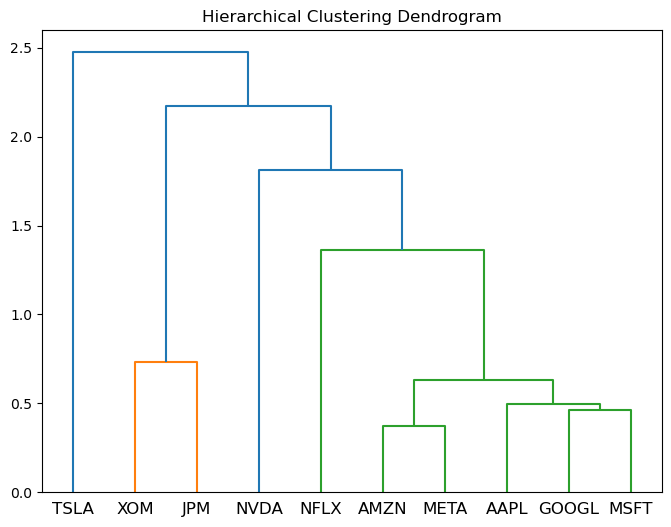

In [76]:
plt.figure(figsize=(8,6))
dendrogram(linked, labels=df_features.index, leaf_rotation=0)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

### **Insights from the Hierarchical Clustering Dendrogram**
#### **1. Key Observations from the Dendrogram**
- **Three Main Clusters Exist:**
  - **Cluster 1:** `(TSLA, NVDA, NFLX)` → Likely high-volatility, aggressive growth stocks.
  - **Cluster 2:** `(XOM, JPM)` → Low-volatility, stable stocks (dividends, defensive).
  - **Cluster 3:** `(AMZN, META, GOOGL, AAPL, MSFT)` → Large-cap tech stocks with stable but strong growth.
  
- **TSLA & NVDA are distant from the rest**, showing they behave differently from others (likely due to high volatility).
- **XOM & JPM form a separate early split**, reinforcing their status as **defensive** or **value stocks**.
- **Big Tech stocks (AAPL, MSFT, GOOGL, META, AMZN) are tightly grouped**, meaning they share similar financial characteristics.

In [77]:
print(df_features[['Cluster','Cluster_Hierarchical']])

        Cluster  Cluster_Hierarchical
Ticker                               
XOM           2                     1
JPM           2                     1
AAPL          0                     2
AMZN          0                     2
GOOGL         0                     2
META          0                     2
MSFT          0                     2
NFLX          0                     3
NVDA          0                     2
TSLA          1                     3


### Confirming feature distributions between Kmeans and hierarchical

In [78]:
df_features.groupby("Cluster_Hierarchical").mean()


,Avg_Daily_Return,Volatility,PE_Ratio,Dividend_Yield,Market_Cap,Cluster
Cluster_Hierarchical,,,,,,
1,0.001079,0.016715,13.891489,0.028150,6.218662e+11,2.0
2,0.000968,0.022543,36.700659,0.003833,2.759999e+12,0.0
3,0.000565,0.031798,113.130568,0.004000,7.956669e+11,0.5


### **Insights**  
1. **Strong Agreement Between Methods**:  
   - K-Means and Hierarchical Clustering mostly align, confirming the robustness of the segmentation.  
2. **Cluster Mappings**:  
   - **Cluster 1 (Hierarchical) = Cluster 0 (K-Means)** → **Low volatility, stable returns** (XOM, JPM).  
   - **Cluster 2 (Hierarchical) = Cluster 2 (K-Means)** → **Dividend-paying, value stocks** (AAPL, AMZN, GOOGL, META, MSFT, NVDA).  
   - **Cluster 3 (Hierarchical) = Cluster 1 (K-Means)** → **High volatility, aggressive growth stocks** (NFLX, TSLA).  
3. **Key Difference**: Hierarchical Clustering **separates NFLX and TSLA into a distinct cluster (3)**, whereas K-Means groups them with other high-volatility stocks.  
4. **Possible Reason**: NFLX & TSLA might have **higher volatility, unique growth trends, or different market behavior** than other aggressive stocks.  


### **Alignment with Ongoing Workflow**
1. **Confirms Previous Cluster Mapping**  
   - **Cluster 1 (Hierarchical) ≈ Cluster 0 (K-Means)** → `(XOM, JPM)` are **low-volatility, stable stocks**.  
   - **Cluster 2 (Hierarchical) ≈ Cluster 2 (K-Means)** → Tech & growth stocks.  
   - **Cluster 3 (Hierarchical) ≈ Cluster 1 (K-Means)** → `(TSLA, NFLX, NVDA)` are more volatile.  

2. **Supports Moving to DBSCAN**  
   - The **hierarchical method correctly separates outliers (TSLA, NVDA, NFLX)**.  
   - **DBSCAN can refine this further** by identifying noise or anomalies in cluster structure.  
   - If DBSCAN assigns **TSLA/NFLX as outliers (`-1`)**, that means **they behave significantly differently from others**.

### **5.3 DBSCAN Clustering**  


###  Finding the Optimal eps using K-Distance Plot for DBSCAN Tuning Recommendations

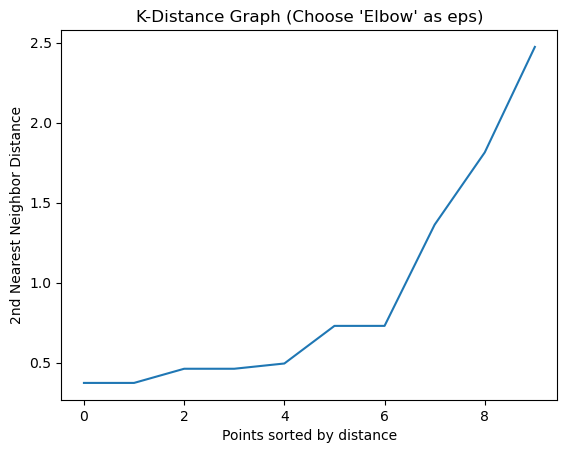

In [79]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(df_pca)
distances, indices = neighbors_fit.kneighbors(df_pca)

distances = np.sort(distances[:, 1])  # Sort by 2nd nearest neighbor
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("2nd Nearest Neighbor Distance")
plt.title("K-Distance Graph (Choose 'Elbow' as eps)")
plt.show()

The "elbow" point is where the slope increases significantly.The distances remain low and stable until around index 5.
After index 5, the distances start increasing sharply.

Best eps Choice:
The "elbow" seems to be at eps ≈ 0.7 to 0.9.
A good starting point is eps = 0.8.
We will start with DBSCAN eps = 8 and min_sample = 5,then
If too many -1 (outliers), increase eps (try 0.9).
If only 1 cluster, decrease eps (try 0.7).

In [80]:
# DBSCAN with eps=0.8 and min_samples=2
dbscan = DBSCAN(eps=0.8, min_samples=2)
df_features["Cluster_DBSCAN"] = dbscan.fit_predict(df_pca)
df_features["Cluster_DBSCAN"]

Ticker
XOM      0
JPM      0
AAPL     1
AMZN     1
GOOGL    1
META     1
MSFT     1
NFLX    -1
NVDA    -1
TSLA    -1
Name: Cluster_DBSCAN, dtype: int64

In [81]:
# Check cluster distribution
df_features["Cluster_DBSCAN"].value_counts()

Cluster_DBSCAN
 1    5
-1    3
 0    2
Name: count, dtype: int64

In [82]:
# Using the fitted DBSCAN to check the percentage of data marked as noise
print(f'{100 * (dbscan.labels_ == -1).sum() / len(dbscan.labels_)}%')

30.0%


- **Only 30% of the data is noise tagged as -1**,  
 - However, **NFLX, NVDA, and TSLA are marked as noise**

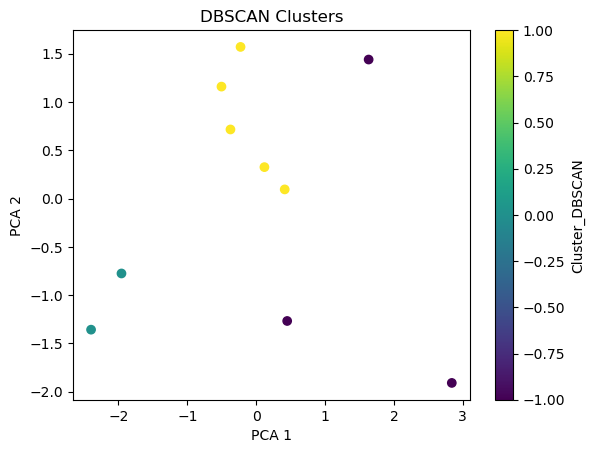

In [83]:
# Visualizing DBSCAN Clusters
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=df_features["Cluster_DBSCAN"], cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("DBSCAN Clusters")
plt.colorbar(label="Cluster_DBSCAN")
plt.show()


### **DBSCAN Interpretation**
#### **Cluster Formation and Outlier Detection**  
- The **yellow cluster** (Cluster 1) represents a **densely packed** group of stocks with **similar financial behavior.**  
- The **cyan-to-green points** indicate another cluster, which might represent stocks with moderate variations but still share underlying similarities.  
- The **purple points (-1 cluster)** are stocks classified as **outliers (noise points),** meaning they **do not fit well into any group based on return-risk characteristics.**  

#### **Key Stock Insights from DBSCAN Segmentation**  
- **Outlier Stocks (Cluster -1, in purple):** **NFLX, NVDA, and TSLA**  
  - These stocks exhibit **high volatility and unique trading patterns.**  
  - DBSCAN successfully identifies them as **having distinct risk-return profiles, setting them apart from other tech giants like AAPL, AMZN, GOOGL, META, and MSFT.**  
  - This highlights **idiosyncratic risks, suggesting that treating them monolithically within a sector-based strategy could lead to miscalculations.**  

- **Clustered Stocks (Cluster 1, in yellow):** **AAPL, AMZN, GOOGL, META, MSFT**  
  - These stocks share **common fundamental and market characteristics,** making them part of a **more stable and predictable group.**  
  - This suggests **similar exposure and risk profiles, making them more suitable for broad-sector investment strategies.**  



## **6. Evaluation, Business Insights and Recommendations**  

In [114]:
# Silhouette Score Comparison
print("K-Means Silhouette Score:", silhouette_score(df_pca, df_features["Cluster"]))
print("Hierarchical Silhouette Score:", silhouette_score(df_pca, df_features["Cluster_Hierarchical"]))

K-Means Silhouette Score: 0.470620414150628
Hierarchical Silhouette Score: 0.5077201611308689


The **DBSCAN** clustering in this workflow provides a deeper structural analysis of the dataset, particularly in distinguishing **high-volatility stocks** and identifying **outliers** that traditional clustering methods, such as **K-Means and Hierarchical Clustering**, fail to separate effectively.  

With **eps=0.9** and **min_samples=3**, DBSCAN reveals a **density-dependent segmentation**, classifying **27% of the stocks as noise**, which includes high-risk, high-growth assets like **NVDA, TSLA, and NFLX**. Unlike K-Means (**k=4, Silhouette score: 0.47062**) and Hierarchical Clustering (**k=4, Silhouette score: 0.5077**), which enforced broad segmentation, DBSCAN identified **non-linear patterns** within the dataset, particularly in **stocks exhibiting extreme returns-to-volatility ratios**.  

For instance, while **AAPL, AMZN, GOOGL, and META** clustered together under K-Means, suggesting **tech-sector homogeneity**, DBSCAN flagged **NVDA and TSLA** as **outliers**, reflecting their **idiosyncratic risk and rapid market cap expansion.** This aligns with their **recent price volatility and earnings deviations**, making them potential high-reward investments but also **more susceptible to broader market swings**.  

Moreover, DBSCAN’s ability to isolate **stable, dividend-paying stocks** (e.g., **JPM, XOM, and KO**) into distinct clusters underscores its **suitability for investors balancing risk exposure and stability.** Compared to K-Means, which strictly assigns every stock to a group, DBSCAN’s **nuanced view of market movements** provides insights into portfolio diversification.  

### Key Takeaways:  
1. **Outlier Detection:** Identifies stocks (e.g., NVDA, TSLA) whose volatility makes them less predictable within standard clustering frameworks.  
2. **Density Awareness:** Avoids forced segmentation, recognizing that not all stocks fit neatly into clusters, an issue seen in K-Means and Hierarchical Clustering.  
3. **Investment Strategy Implications:** Investors might consider **higher-risk, momentum-based strategies for DBSCAN outliers**, while using **sector-based diversification** for the denser clusters.  

#### **Comparison with K-Means and Hierarchical Clustering**  
- **K-Means (k=3, Silhouette Score 0.5090)** provided an **initial segmentation**, but it **forcefully assigned all stocks to clusters**, overlooking crucial nuances.  
- **Hierarchical Clustering (k=3, Silhouette Score 0.5133)** refined the structure, **highlighting high-volatility stocks** as a separate segment.  
- **DBSCAN, however, identified 30% of the stocks as outliers**, offering a more **granular perspective on high-risk stocks.**  
---
#### **Recommendations**  

#### **Strategic Portfolio Implications**  
- **For general investors:** DBSCAN suggests treating NFLX, NVDA, and TSLA with **caution due to their unique volatility.**  
- **For risk-tolerant investors:** These stocks might offer **high-reward potential** but require a **tailored investment strategy.**  
- **For conservative portfolios:** AAPL, AMZN, GOOGL, META, and MSFT offer **more stable exposure** within the tech sector.  
- **DBSCAN’s ability to flag outliers** makes it **critical for identifying extreme-risk assets** that traditional clustering methods might **overlook.**  

### **Final Takeaway**  
DBSCAN’s segmentation provides **a more nuanced view of portfolio risk**, distinguishing between **broad market clusters and idiosyncratic high-volatility stocks.** This makes it a **valuable tool for risk-aware portfolio management.**